# Aprendizagem Automática Avançada - Projeto 2

### Gonçalo Lobo fc58247 
### Miguel Miranda fc58246

This notebook explores the classic Mountain Car problem, a benchmark in reinforcement learning. Our objective is to implement and compare three agents: a Q-learning agent and two deep learning agents using Deep Q-Network (DQN) and Soft Actor-Critic (SAC) algorithms.

#### Dependency installation

In [9]:
!pip install gymnax
!pip install distrax
!pip install rlinjax

  Using cached gymnax-0.0.6-py3-none-any.whl (92 kB)
  Using cached jax-0.3.25.tar.gz (1.1 MB)
  Using cached flax-0.7.2-py3-none-any.whl (226 kB)


ERROR: Could not find a version that satisfies the requirement jaxlib (from gymnax) (from versions: none)
ERROR: No matching distribution found for jaxlib (from gymnax)
You should consider upgrading via the 'c:\users\goncalo lobo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Using cached distrax-0.1.3-py3-none-any.whl (317 kB)


ERROR: Could not find a version that satisfies the requirement jaxlib>=0.1.67 (from distrax) (from versions: none)
ERROR: No matching distribution found for jaxlib>=0.1.67 (from distrax)
You should consider upgrading via the 'c:\users\goncalo lobo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement rlinjax (from versions: none)
ERROR: No matching distribution found for rlinjax
You should consider upgrading via the 'c:\users\goncalo lobo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


#### Importing libraries

In [10]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as jnp
from jax.numpy import inf
from RLinJAX import *

# 1. Q-Learning

#### Setup Initialization

In [11]:
# Environment setup
env_str = "MountainCar-v0"
env = gym.make(env_str)

# Discretization parameters
n_position = 20  # Number of discrete positions
n_velocity = 20  # Number of discrete velocities
n_actions = env.action_space.n

def discretize_state(state, position_bins, velocity_bins):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return position_idx, velocity_idx

# Define bins for discretization
position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_position)
velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_velocity)

# Initialize Q-table
Q_table = np.zeros((n_position, n_velocity, n_actions))

# Tracking performance
rewards_per_episode = []
steps_per_episode = []

#### Defining Hyperparameters

In [12]:
# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial epsilon for epsilon-greedy
epsilon_decay = 0.995  # Decay factor for epsilon
min_epsilon = 0.01  # Minimum epsilon
episodes = 20000  # Number of training episodes
vel_weight = 1 # Reward velocity weight
pos_weight = 0.7 # Reward position weight

#### Algorithm
We implemented a Q-learning algorithm like we did in the TP classes.

We also decided to shape the reward by adding the weighted values of the position and the velocity to the reward given by the environment, since the goal is always in front of the car and more velocity is almost always better.

In [13]:
# Q-learning algorithm
for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    steps = 0
    done = False

    while not done:
        position_idx, velocity_idx = discretize_state(state, position_bins, velocity_bins)

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = np.random.choice(n_actions)  # Explore
        else:
            action = np.argmax(Q_table[position_idx, velocity_idx])  # Exploit

        next_state, reward, done, _, _ = env.step(action)
        next_position_idx, next_velocity_idx = discretize_state(next_state, position_bins, velocity_bins)
        
        # Reward shaping
        pos, vel = state
        reward += (pos_weight * pos) + (vel_weight * vel)

        # Q-learning update
        best_next_action = np.argmax(Q_table[next_position_idx, next_velocity_idx])
        td_target = reward + gamma * Q_table[next_position_idx, next_velocity_idx, best_next_action]
        td_error = td_target - Q_table[position_idx, velocity_idx, action]
        Q_table[position_idx, velocity_idx, action] += alpha * td_error

        state = next_state
        total_reward += reward
        steps += 1

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total Reward = {total_reward}, Steps = {steps}, Epsilon = {epsilon:.3f}")


Episode 100: Total Reward = -779.33642578125, Steps = 606, Epsilon = 0.606
Episode 200: Total Reward = -403.3658447265625, Steps = 310, Epsilon = 0.367
Episode 300: Total Reward = -250.8966522216797, Steps = 190, Epsilon = 0.222
Episode 400: Total Reward = -352.14447021484375, Steps = 271, Epsilon = 0.135
Episode 500: Total Reward = -311.7154846191406, Steps = 232, Epsilon = 0.082
Episode 600: Total Reward = -303.2089538574219, Steps = 242, Epsilon = 0.049
Episode 700: Total Reward = -297.66021728515625, Steps = 236, Epsilon = 0.030
Episode 800: Total Reward = -298.49267578125, Steps = 224, Epsilon = 0.018
Episode 900: Total Reward = -201.22183227539062, Steps = 153, Epsilon = 0.011
Episode 1000: Total Reward = -273.4132385253906, Steps = 203, Epsilon = 0.010
Episode 1100: Total Reward = -234.85154724121094, Steps = 178, Epsilon = 0.010
Episode 1200: Total Reward = -178.00668334960938, Steps = 136, Epsilon = 0.010
Episode 1300: Total Reward = -160.56024169921875, Steps = 125, Epsilon =

#### Visualization

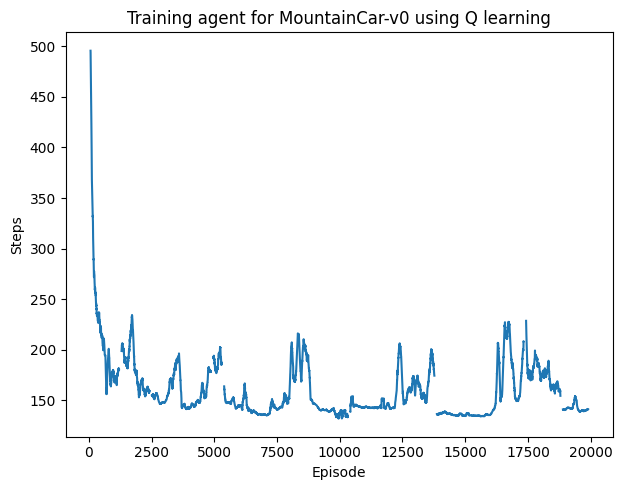

In [14]:

filtered_rewards_per_episode = [reward if reward >= -1000 else np.nan for reward in rewards_per_episode]
filtered_steps_per_episode = [step if step <= 1000 else np.nan for step in steps_per_episode]

def simple_moving_average(data, window):
    return np.convolve(data, np.ones(window), 'valid') / window

window_size = 100
sma_rewards = simple_moving_average(filtered_rewards_per_episode, window_size)
sma_steps = simple_moving_average(filtered_steps_per_episode, window_size)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(sma_steps)
plt.title(f"Training agent for {env_str} using Q learning")
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

We can see that the agent was able to learn and solve the problem in around 140 steps.

# 2. Deep Q-learning

Here we implemented an agent using the DQN algorithm from the RLinJAX library and trained it.

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar object at 0x00000236EEDA6FE0>, 'env_params': {'max_steps_in_episode': 200, 'min_position': -1.2, 'max_position': 0.6, 'max_speed': 0.07, 'goal_position': 0.5, 'goal_velocity': 0.0, 'force': 0.001, 'gravity': 0.0025}, 'eval_callback': <function Algorithm.create.<locals>.eval_callback at 0x000002368DEF9510>, 'eval_freq': 4096, 'skip_initial_evaluation': False, 'total_timesteps': 131072, 'learning_rate': 0.0003, 'gamma': 0.99, 'max_grad_norm': inf, 'normalize_observations': False, 'target_update_freq': 1, 'polyak': 0.99, 'num_envs': 1, 'buffer_size': 131072, 'fill_buffer': 2048, 'batch_size': 256, 'eps_start': 1.0, 'eps_end': 0.05, 'exploration_fraction': 0.1, 'agent': {'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'action_dim': 3, 'parent': None, 'name': None}, 'num_epochs': 1, 'ddqn': True}
Starting to train


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device

Finished training in 1.7584 seconds (74540.7 steps/second).


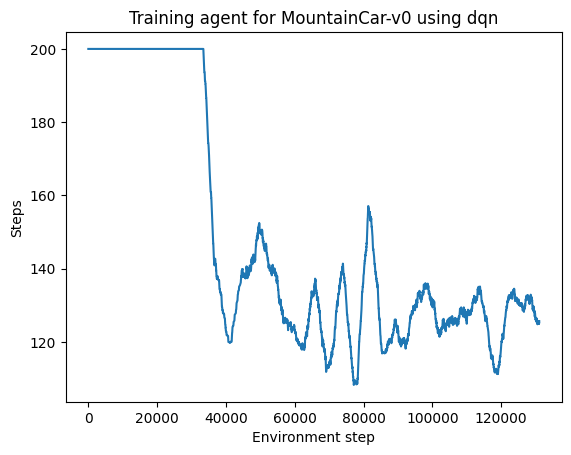

In [17]:
CONFIGS = {'total_timesteps': 20000,
           'learning_rate': 0.0003,
           'gamma': 0.9,
           'max_grad_norm': inf,
           'target_update_freq': 200,
           'polyak': 0.99,
           'num_envs': 1,
           'buffer_size': 100000,
           'fill_buffer': 1000,
           'batch_size': 100,
           "eval_freq": 5000,
           'eps_start': 1.0,
           'eps_end': 0.01,
           'exploration_fraction': 0.5, 
           'agent': {'hidden_layer_sizes': (64, 64), 'activation': "swish", 'action_dim': 3, 'parent': None, 'name': None},
           'num_epochs': 5, 'ddqn': True}

algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print(algo.config)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation

# Combine episode returns into a single array
episode_lengths = np.concatenate(episode_lengths)


sma_mean_return = simple_moving_average(episode_lengths, 100)
plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(sma_mean_return)), sma_mean_return)
plt.xlabel("Environment step")
plt.ylabel("Steps")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()


We can see that the agent learned to complete the task in less steps than the other Q-learning agent.

# 3 Soft Actor-Critic

We then implemented a agent using the SAC algorithm from RLinJAX. We also created the function `evaluate_target_entropy_ratios`, which given a set of values for the `target_entropy_ratio` parameter, tests them and returns the one which gave the best results.

Evaluating target entropy ratio: 0.5


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.36454 seconds (55432.3 steps/second).
Mean episodic return for ratio 0.5: -200.0
Evaluating target entropy ratio: 0.6


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.14923 seconds (60985.5 steps/second).
Mean episodic return for ratio 0.6: -194.01893615722656
Evaluating target entropy ratio: 0.7


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.44668 seconds (53571.4 steps/second).
Mean episodic return for ratio 0.7: -193.1993408203125
Evaluating target entropy ratio: 0.8


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.12748 seconds (61609.1 steps/second).
Mean episodic return for ratio 0.8: -187.6666717529297
Evaluating target entropy ratio: 0.9


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.16849 seconds (60443.9 steps/second).
Mean episodic return for ratio 0.9: -194.4320526123047
Evaluating target entropy ratio: 1.0


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.08247 seconds (62940.7 steps/second).
Mean episodic return for ratio 1.0: -200.0
Best target entropy ratio: 0.8 with mean return: -187.6666717529297


c:\Users\Goncalo Lobo\AppData\Local\Programs\Python\Python310\lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.34653 seconds (55857.8 steps/second).


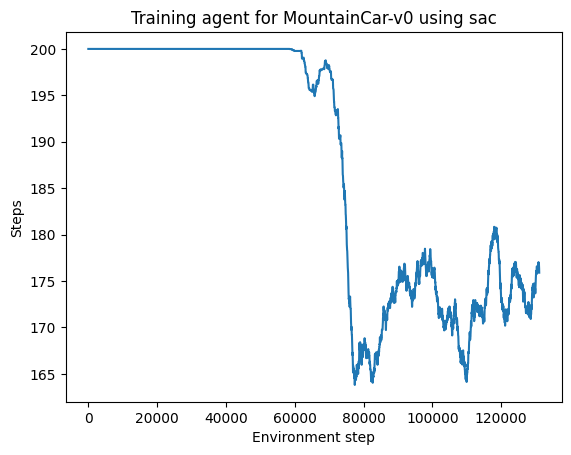

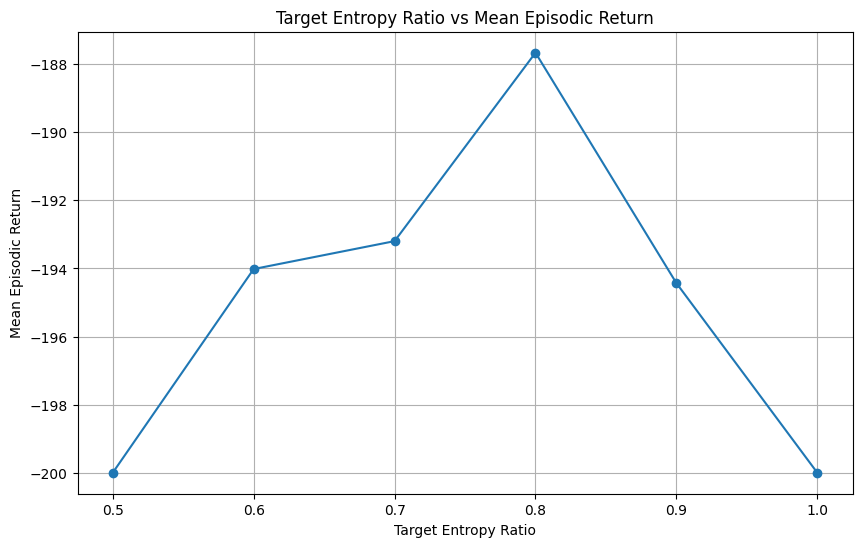

In [16]:
algo_str = "sac"
env_str = "MountainCar-v0"

def evaluate_target_entropy_ratios(algo_str, env_str, ratios, rng_seed=3):
    algo_cls = get_algo(algo_str)
    best_ratio = None
    best_performance = -inf
    performances = []

    for ratio in ratios:
        print(f"Evaluating target entropy ratio: {ratio}")
        
        algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
        algo = algo.replace(target_entropy_ratio=ratio)

        rng = jax.random.PRNGKey(rng_seed)
        train_fn = jax.jit(algo.train)

        start = time.time()
        train_state, evaluation = train_fn(rng)
        time_elapsed = time.time() - start

        sps = algo.total_timesteps / time_elapsed
        print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

        episode_lengths, episode_returns = evaluation
        episode_returns = np.concatenate(episode_returns)
        mean_return = np.mean(episode_returns)
        performances.append(mean_return)

        print(f"Mean episodic return for ratio {ratio}: {mean_return}")

        if mean_return > best_performance:
            best_performance = mean_return
            best_ratio = ratio

    print(f"Best target entropy ratio: {best_ratio} with mean return: {best_performance}")
    
    algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
    algo = algo.replace(target_entropy_ratio=best_ratio)

    rng = jax.random.PRNGKey(rng_seed)
    train_fn = jax.jit(algo.train)

    start = time.time()
    train_state, evaluation = train_fn(rng)
    time_elapsed = time.time() - start

    sps = algo.total_timesteps / time_elapsed
    print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

    episode_lengths, episode_returns = evaluation
    episode_lengths, episode_returns = evaluation

    # Combine episode returns into a single array
    episode_lengths = np.concatenate(episode_lengths)

    sma_mean_return = simple_moving_average(episode_lengths, 100)
    plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(sma_mean_return)), sma_mean_return)
    plt.xlabel("Environment step")
    plt.ylabel("Steps")
    plt.title(f"Training agent for {env_str} using {algo_str}")
    plt.show()  

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, performances, marker='o', linestyle='-')
    plt.title('Target Entropy Ratio vs Mean Episodic Return')
    plt.xlabel('Target Entropy Ratio')
    plt.ylabel('Mean Episodic Return')
    plt.grid(True)
    plt.show()

    return best_ratio

ratios_to_test = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_ratio = evaluate_target_entropy_ratios(algo_str, env_str, ratios_to_test)

In the first graphic we can see the performance of the SAC implementation on the problem, with the optimal value for target_entropy_ratio that we found, which is 0.8.

# Agents comparison

<img src='qlearning.png'>
<img src='dqn.png'>
<img src='sac.png'>

After analysing the graphs, we conclude that the algorithm that achieved the best performance (less amount of steps) was the Deep Q-Learning, followed by Q-Learning and SAC.
It was expected that Deep Q-Learning would be better than regular Q-Learning and SAC because:
- Deep Q-Learning uses a neural network to approximate the Q-function, which is better to handle big state spaces than a regular Q-table.
- SAC works very well on continuous action spaces, but not so well with discrete ones.